## 1. Requirements

In [1]:
import numpy as np
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
%cd /content/drive/MyDrive/AdversarialExampleTutorial21/day02/attack/sample_case_01

/content/drive/MyDrive/AdversarialExampleTutorial21/day02/attack/sample_case_01


In [13]:
!ls

data  PGD.ipynb


## 2. Set Args

In [14]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

## 3. Prepare Data

In [15]:
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [16]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
])

In [17]:
def image_folder_custom_label(root, transform, custom_label) :
    
    # custom_label
    # type : List
    # index -> label
    # ex) ['tench', 'goldfish', 'great_white_shark', 'tiger_shark']
    
    old_data = dsets.ImageFolder(root = root, transform = transform)
    old_classes = old_data.classes
    
    label2idx = {}
    
    for i, item in enumerate(idx2label) :
        label2idx[item] = i
    
    new_data = dsets.ImageFolder(root = root, transform = transform, 
                                 target_transform = lambda x : custom_label.index(old_classes[x]))
    new_data.classes = idx2label
    new_data.class_to_idx = label2idx

    return new_data

In [79]:
normal_data = image_folder_custom_label(root = './data/imagenet', transform = transform, custom_label = idx2label)
normal_loader = Data.DataLoader(normal_data, batch_size=6, shuffle=False)

In [80]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (15, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    
    plt.axis('off')
    plt.show()

True Image & True Label


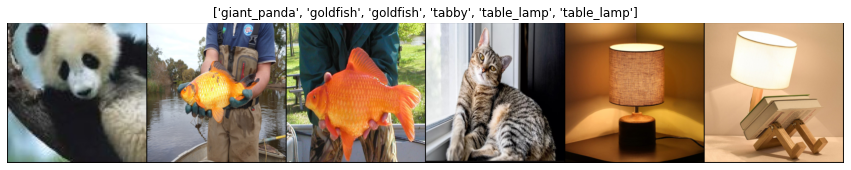

In [81]:
normal_iter = iter(normal_loader)
images, labels = normal_iter.next()

print("True Image & True Label")
imshow(torchvision.utils.make_grid(images, normalize=True), [normal_data.classes[i] for i in labels])

## 4. Download the Inception v3

In [82]:
model = models.inception_v3(pretrained=True).to(device)

True Image & Predicted Label


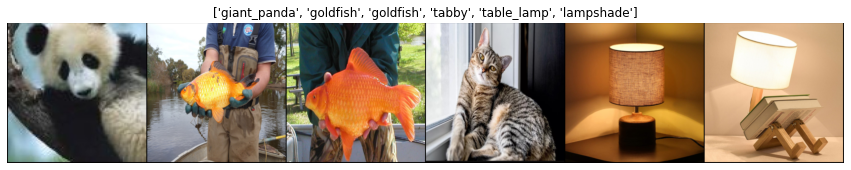

In [85]:
print("True Image & Predicted Label")

model.eval()

for images, labels in normal_loader:
    
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    
    _, pre = torch.max(outputs.data, 1)
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])

## 5. Adversarial Attack

$$x^{t+1} = \Pi_{x+S}(x^t+\alpha sgn(\bigtriangledown_x L(\theta, x, y)))$$
* $S$ : a set of allowed perturbations

In [94]:
# PGD Attack
# MNIST init
def pgd_attack(model, images, labels, eps=0.3, alpha=2/255, iters=40) :
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()
        
    ori_images = images.data
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
            
    return images

Attack Image & Predicted Label


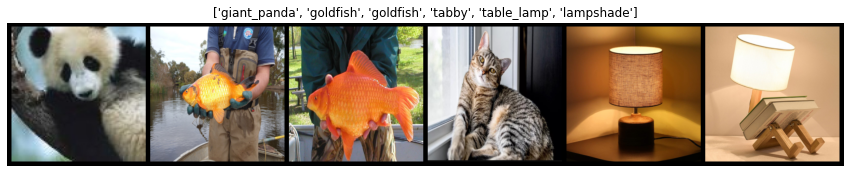

Accuracy of test text: 83.333333 %


83.33333333333333

In [92]:
print("Attack Image & Predicted Label")  
model.eval()

def mytest(normal_loader=normal_loader,eps=0,itr=100):
  
  correct = 0
  total = 0
  for images, labels in normal_loader:
      
      images = pgd_attack(model, images, labels,eps=eps,iters=itr)
      labels = labels.to(device)
      outputs = model(images)
      
      _, pre = torch.max(outputs.data, 1)

      total += 1
      correct += (pre == labels).sum()
      
      imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True,padding=10), [normal_data.classes[i] for i in pre])
      
  acc =100 * float(correct) / len(normal_loader.dataset)
  print('Accuracy of test text: %f %%' % (acc))
  print('==================================================')
  return acc

mytest(normal_loader=normal_loader,eps=0,itr=100)

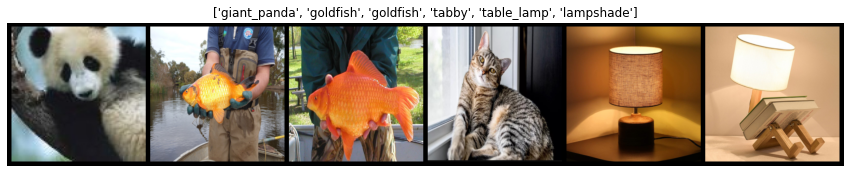

Accuracy of test text: 83.333333 %


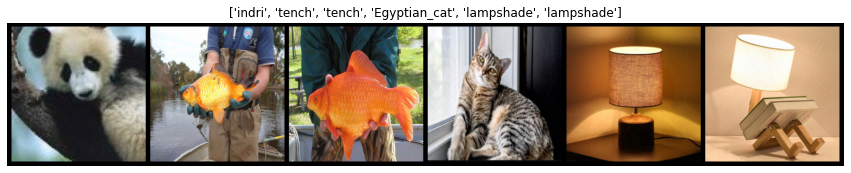

Accuracy of test text: 0.000000 %


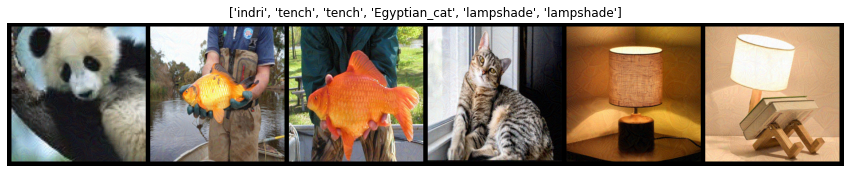

Accuracy of test text: 0.000000 %


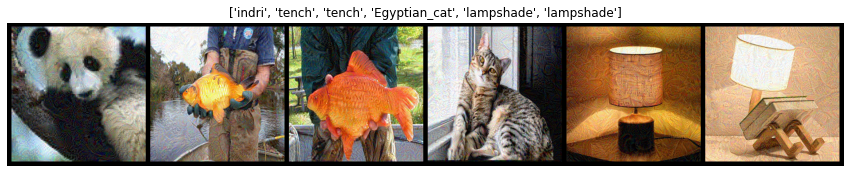

Accuracy of test text: 0.000000 %


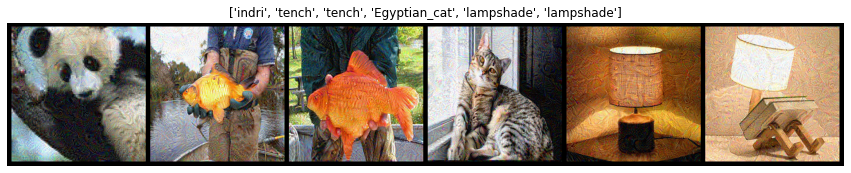

Accuracy of test text: 0.000000 %


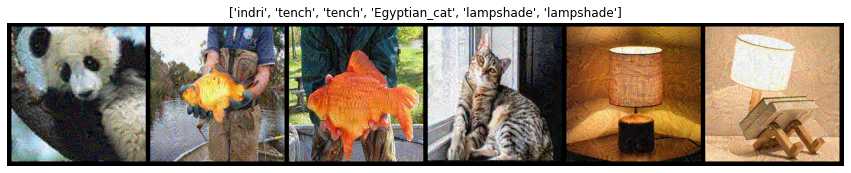

Accuracy of test text: 0.000000 %


In [93]:
epsilons = [0, .01, .03, .1, .2, .3]
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc = mytest(eps=eps)
    accuracies.append(acc)

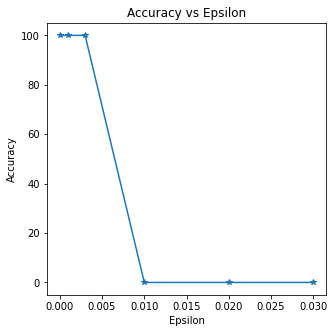

In [61]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
# plt.yticks(np.arange(0, 1.1, step=0.1))
# plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()